In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import  matplotlib.pyplot as plt

In [4]:
train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=transforms.ToTensor(), download=True)

In [5]:
test_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=transforms.ToTensor(), download=True)

In [6]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            # nonlinearity='relu',
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [10]:
model = SimpleRNN(n_inputs=28, n_hidden=128, n_rnnlayers=2, n_outputs=10)
model.to(device)

SimpleRNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
epochs = 10

train_losses = []
test_losses = []

for i in range(epochs):
    train_loss = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs = inputs.view(-1, 28, 28)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    train_loss = np.mean(train_loss)
    
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 28, 28)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
        
    test_loss = np.mean(test_loss)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)   
    
    print(f"Epoch {i + 1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")

Epoch 1/10, train_loss: 0.5667, test_loss: 0.1549
Epoch 2/10, train_loss: 0.1322, test_loss: 0.1367
Epoch 3/10, train_loss: 0.0874, test_loss: 0.0675
Epoch 4/10, train_loss: 0.0668, test_loss: 0.0720
Epoch 5/10, train_loss: 0.0534, test_loss: 0.0561
Epoch 6/10, train_loss: 0.0443, test_loss: 0.0530
Epoch 7/10, train_loss: 0.0396, test_loss: 0.0498
Epoch 8/10, train_loss: 0.0314, test_loss: 0.0438
Epoch 9/10, train_loss: 0.0279, test_loss: 0.0426
Epoch 10/10, train_loss: 0.0258, test_loss: 0.0459


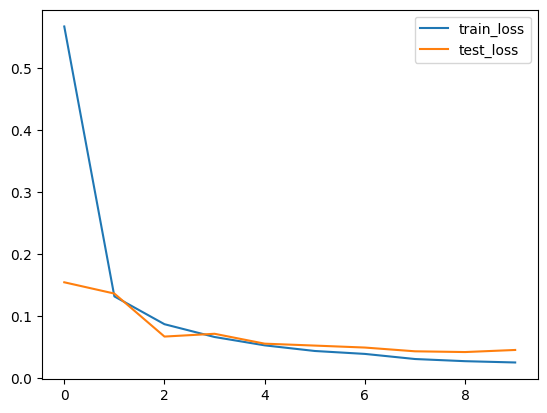

In [13]:
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [14]:
def calculate_acc(data_loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs = inputs.view(-1, 28, 28)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
        
    acc = n_correct / n_total
    return acc

In [15]:
train_acc = calculate_acc(train_loader)
test_acc = calculate_acc(test_loader)

print(f"train_acc: {train_acc}, test_acc: {test_acc}")

train_acc: 0.99145, test_acc: 0.9867
